# Visualizing hyperband-optimization: Connecting HpBandSter and CAVE

In this notebook, we present an example on how to connect our tools <a href="https://github.com/automl/CAVE" target="_blank">CAVE</a> and <a href="https://github.com/automl/HpBandSter" target="_blank">HpBandSter</a> to efficiently optimize a neural network and subsequently analyze and visualize the optimization process.

## About the frameworks

### HpBandSter

<a href="https://github.com/automl/HpBandSter" target="_blank">HpBandSter</a> (HyperBand on Steroids) implements recently published methods for optimizing hyperparameters of machine learning algorithms. One of the implemented algorithms is <a href="https://automl.github.io/HpBandSter/build/html/optimizers/bohb.html" target="_blank">BOHB</a>, combining Bayesian Optimization and HyperBand to efficiently search for well performing configurations. Learn more about this method by reading our paper, published at <a href="http://proceedings.mlr.press/v80/falkner18a.html" target="_blank">ICML 2018</a>.

### CAVE

<a href="https://github.com/automl/CAVE" target="_blank">CAVE</a> (Configuration Assessment, Visualization and Evaluation) is designed to create comprehensive reports about an optimization process. The resulting figures and interactive plots can be used to gain insights in the parameter importance, feature importance, search behaviour and quality. Learn more about CAVE from <a href="https://www.ml4aad.org/algorithm-analysis/cave/" target="_blank">our paper</a>.

### Installation requirements

You need to install HpBandSter and CAVE to run this example. Both can be installed using pip (i.e. `pip install cave hpbandster`).

## Running BOHB


In [1]:
# We deactivate logging to ensure readability
import logging
logging.basicConfig(level=logging.ERROR)
# Also, we suppress warnings.
# If there are problems for you executing this notebook, you might want to comment this out.
import warnings
warnings.filterwarnings("ignore")

### 1.1) Preparing BOHB
*Worker*: We need a <a href="https://automl.github.io/HpBandSter/build/html/core/worker.html" target="_blank">Worker</a> to define the kind of computation we want to optimize. An exemplary worker computing the validation loss of a configurable network on the digits dataset can be found under `example_mlp_on_digits.py`.

*ConfigSpace*: Every problem needs a description of the search space to be complete. In HpBandSter, a ConfigurationSpace-object defines all hyperparameters, their ranges and dependencies between them.

In our example here, the search space consists of the hyperparameters:

|         Name        |     Type    |      Values      |     Condition    |
|:-------------------:|:-----------:|:----------------:|:----------------:|
| activation-function | categorical | {'relu', 'tanh'} |                  |
|    learning-rate    |    float    |   [1e-6 - 1e-2]  |                  |
|        solver       | categorical |  {'sgd', 'adam'} |                  |
|        beta_1       |    float    |      [0, 1]      | solver == 'adam' |
|        beta_2       |    float    |      [0, 1]      | solver == 'adam' |

In [3]:
from worker import MyWorker, get_configspace

### 1.3) Setting up the HpBandSter Nameserver and starting the optimization run

**NOTE:** Unfortunately, the configuration space is *not saved automatically* to file but this step is mandatory for the analysis with CAVE.  
We recommend to save the configuration space every time you use BOHB.
We do this by using the ConfigSpace-to-json-writer.

In [4]:
import os

from ConfigSpace.read_and_write import pcs_new
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB as BOHB

# Create and save a configuration space
config_space = get_configspace()
out_dir = 'example_mlp_on_digits'
os.makedirs(out_dir, exist_ok=True)
with open(os.path.join(out_dir, 'configspace.pcs'), 'w') as fh:
    fh.write(pcs_new.write(config_space))

#### Step 1 - initiating communication, creating a nameserver:
The <a href="https://automl.github.io/HpBandSter/build/html/core/nameserver.html" target="_blank">nameserver</a> is a small service that keeps track of all running processes and their IP addresses and ports. It could be a 'static' server with a permanent address, but here it will be started for the local machine with a random port. 

In [5]:
run_id = '0'  # Every run has to have a unique (at runtime) id.
NS = hpns.NameServer(run_id=run_id, host='localhost', port=0)
ns_host, ns_port = NS.start()

#### Step 2 - creating the worker: 
The worker implements the actual problem that is optimized. Its 'compute'-method will be called later by the BOHB-optimizer repeatedly with the sampled configurations and return the computed loss (and additional information).

In [6]:
w = MyWorker(nameserver=ns_host,
             nameserver_port=ns_port,
             run_id=run_id,  # same as nameserver's
            )
w.run(background=True)

#### Step 3:  
Create an optimizer object, which samples configurations from the ConfigurationSpace, using succesive halving to assign budgets for execution. Further information on what qualifies as a budget <a href="https://automl.github.io/HpBandSter/build/html/quickstart.html#meaningful-budgets-and-number-of-iterations" target="_blank">can be found in the documentation.</a>

**NOTE:** BOHB does not build a new model at the beginning of every SuccessiveHalving run. Instead it collects all evaluations on all budgets and uses the largest budget with enough evaluations as a base for future evaluations.  

In [7]:
# Log the optimization results for later analysis
result_logger = hpres.json_result_logger(directory=out_dir, overwrite=True)

bohb = BOHB(  configspace=config_space,
              run_id=run_id,  # same as nameserver's
              eta=2, min_budget=5, max_budget=100,  # Hyperband parameters
              nameserver=ns_host, nameserver_port=ns_port,
              result_logger=result_logger,
           )

# Then start the optimizer. The n_iterations parameter specifies
# the number of iterations to be performed in this run
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res = bohb.run(n_iterations=2)

# After the run is finished, the services started above need to be shutdown.
# This ensures that the worker, the nameserver and the master all properly exit
# and no (daemon) threads keep running afterwards.
# In particular we shutdown the optimizer (which shuts down all workers) and the nameserver.
bohb.shutdown(shutdown_workers=True)
NS.shutdown()

The <a href="https://automl.github.io/HpBandSter/build/html/core/result.html" target="_blank">Result-object</a> offers access to basic statistics, as well as the best configuration (incumbent) and the trajectory.

A total of 24 unique configurations where sampled.
A total of 46 runs where executed.
Best configuration found: {'activation': 'tanh', 'learning_rate_init': 0.00531926399119054, 'solver': 'adam', 'beta_1': 0.3672921741318445, 'beta_2': 0.7708072177436147}


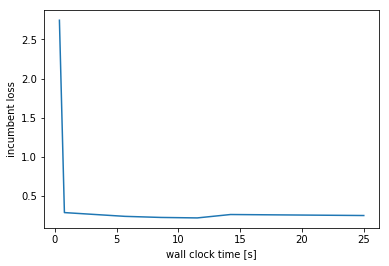

In [8]:
# The returned result object holds informations about the optimization run
# like the incumbent (=best) configuration.
id2config = res.get_id2config_mapping()
print('A total of %i unique configurations where sampled.' % len(id2config.keys()))
print('A total of %i runs where executed.' % len(res.get_all_runs()))
print('Best configuration found: {}'.format(id2config[res.get_incumbent_id()]['config']))

# The incumbent trajectory is a dictionary with all the configuration IDs, the times the runs
# finished, their respective budgets, and corresponding losses.
# It's used to do meaningful plots of the optimization process.
incumbent_trajectory = res.get_incumbent_trajectory()

import matplotlib.pyplot as plt
plt.plot(incumbent_trajectory['times_finished'], incumbent_trajectory['losses'])
plt.xlabel('wall clock time [s]')
plt.ylabel('incumbent loss')
plt.show()

## Using the results in CAVE

### 2.1) Creating a HTML-report with CAVE

Creating the report with CAVE is very straight-forward. Simply provide the output-directory of the BOHB-analysis in CAVE's `--folders` argument and specify `--file_format` as `BOHB`. You can do this by commandline ('!' simply executes the command as if it was executed on the command line):


In [ ]:
! cave --folders example_mlp_on_digits --file_format BOHB --output CAVE_bash_mlp_on_digits --verbose_level OFF

After CAVE finished the report, you can have a look at it with your favorite browser.

In [ ]:
! firefox ./CAVE_bash_mlp_on_digits/report.html

### 2.2) Using CAVE from within Python

Of course you can use CAVE on a module-level. Import and instantiate it (very similarily to the commandline). By default, CAVE even outputs all analysis results in a jupyter-cell-compatible way. Of course, the HTML-report is built meanwhile, so you don't have to run time-consuming analyzing-methods repeatedly.

In [9]:
from cave.cavefacade import CAVE

cave = CAVE(folders=["example_mlp_on_digits"],
            output_dir="CAVE_python_mlp_on_digits",
            ta_exec_dir=["."],
            file_format='BOHB',
            verbose_level='OFF',
            show_jupyter=True
           )

The most interesting plot for BOHB might be a visualization of the learning curves:

In [10]:
cave.bohb_learning_curves()

Loading BokehJS ...

We can access the individual budgets via the 'run'-keyword-argument of each analysis-method.

In [11]:
cave.overview_table(run='budget_12.5')

For each budget, we can list the cost over incumbents:

In [12]:
cave.bohb_incumbents_per_budget()

,budget 6.2,budget 12.5,budget 25,budget 50,budget 100
activation,tanh,tanh,tanh,tanh,tanh
learning_rate_init,0.00731865,0.00731865,0.00731865,0.00731865,0.00531926
solver,adam,adam,adam,adam,adam
beta_1,0.367223,0.367223,0.367223,0.367223,0.367292
beta_2,0.771083,0.771083,0.771083,0.771083,0.770807
Cost,0.287,0.239,0.225,0.219,0.249


In [13]:
cave.performance_table(run='budget_25')

,Default,Incumbent
Quality,0.27,0.225


For parameter-importance analysis, CAVE uses <a href="https://github.com/automl/ParameterImportance" target="_blank">PIMP</a> , a package that provides multiple approaches to parameter-importance analysis. We can easily invoke them via CAVE, of course. To estimate the importance, random forests are used to predict performances of configurations that were not executed. This is difficult for big budgets with few configurations.

In [14]:
cave.cave_fanova(run='budget_12.5')

-------------------- Single importance: --------------------,--------------------
learning_rate_init,68.556 +/- 40.301
beta_1,9.5475 +/- 23.5325
beta_2,7.0316 +/- 18.923
activation,3.1235 +/- 7.0994
solver,1.3258 +/- 3.4704
-------------------- Pairwise importance: --------------------,--------------------
beta_1 & activation,2.8469 +/- 7.6601
learning_rate_init & solver,2.7525 +/- 10.2241
activation & solver,1.3186 +/- 5.1068
learning_rate_init & activation,0.8872 +/- 2.3739


In [15]:
cave.local_parameter_importance(run='budget_12.5')

For each budget, we can compare the different parameter-importance-methods that have already been run:

In [16]:
cave.pimp_comparison_table(run='budget_12.5')

Loading BokehJS ...

To analyze BOHB's behaviour, we can check out the configurator footprint, cost-over-time and parallel coordinated parameters:

In [17]:
cave.configurator_footprint(run='budget_12.5', use_timeslider=True, num_quantiles=5)

Loading BokehJS ...

In [18]:
cave.cost_over_time(run="budget_25.0")

Loading BokehJS ...

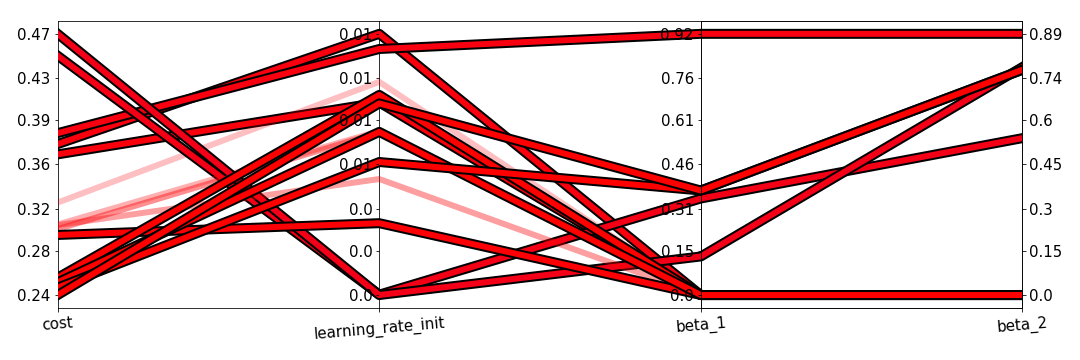

In [19]:
cave.parallel_coordinates(run='budget_12.5')